In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications.densenet import preprocess_input

# Load and prepare the dataset

In [3]:
batch_size = 16
img_height = 224
img_width = 224

In [4]:
data_dir = "D:\\ISEN\\M1\\Projet M1\\DLBCL-Morph\\Patches\\HE"
data_dir = pathlib.Path(data_dir)
list_ds = tf.data.Dataset.list_files(str(data_dir / '*/*'), shuffle=False)
list_ds = list_ds.shuffle(len(list_ds), reshuffle_each_iteration=False)
image_count = len(list_ds)
print(image_count)
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

30007
24006
6001


In [5]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])


def process_path(file_path):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, img


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [6]:
def data_augmentation(batch, blur_range=(0.0, 0.2*255.0), noise_range=(0.0, 0.2*255.0)):
    # Apply random Gaussian blur and noise to each image in the batch
    def augment_image(image):
        # Apply Gaussian blur with random severity within `blur_range`
        blur_sigma = np.random.uniform(*blur_range)
        image = tfa.image.gaussian_filter2d(image, filter_shape=(3, 3), sigma=blur_sigma)

        # Add Gaussian noise with random severity within `noise_range`
        noise_scale = np.random.uniform(*noise_range)
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise_scale)
        image = tf.add(image, noise)

        return image

    augmented_batch = tf.map_fn(augment_image, batch)
    return augmented_batch

In [7]:
train_ds = train_ds.batch(batch_size)

# Extract one batch and apply data augmentation and data preprocessing to it

In [9]:
batch_ = next(iter(train_ds))[0]
augmented_batch_ = data_augmentation(batch_)
preprocessed_augmented_batch = preprocess_input(augmented_batch_)

In [10]:
def show_batch(image_batch):
    plt.figure(figsize=(10, 10))
    for n in range(16):
        plt.subplot(4, 4, n + 1)
        # if the image is a tensor, convert it to a numpy array
        if isinstance(image_batch[n], tf.Tensor):
            plt.imshow(image_batch[n].numpy().astype("uint8"))
        else:
            plt.imshow(image_batch[n].astype("uint8"))
        plt.axis("off")

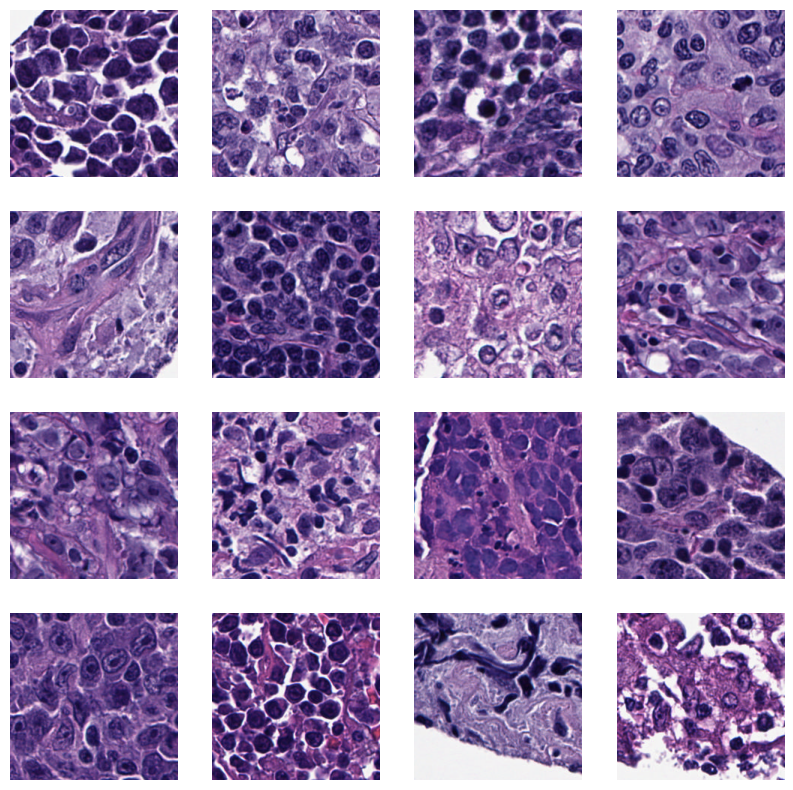

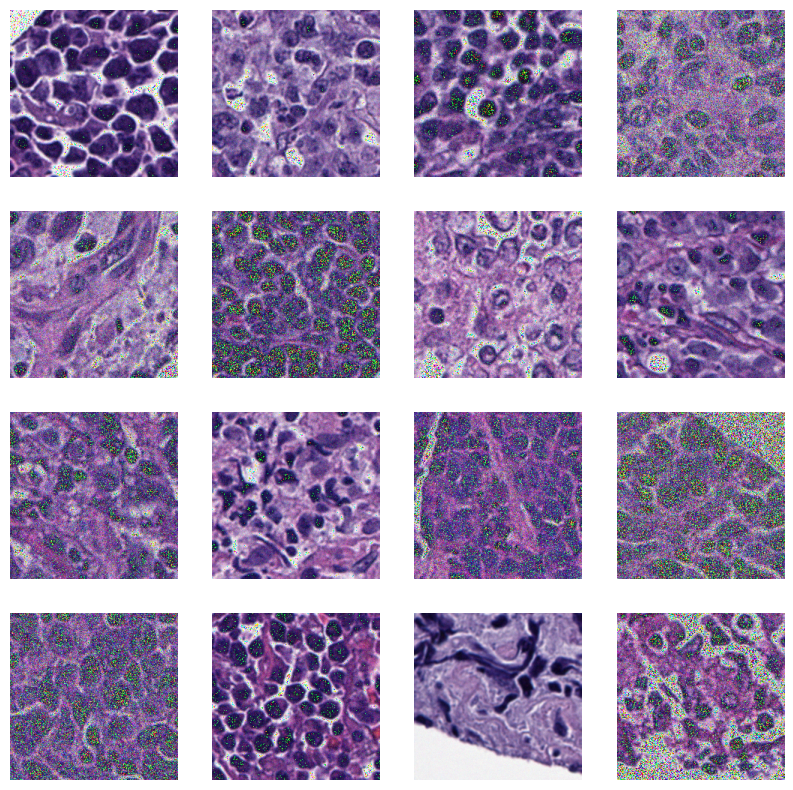

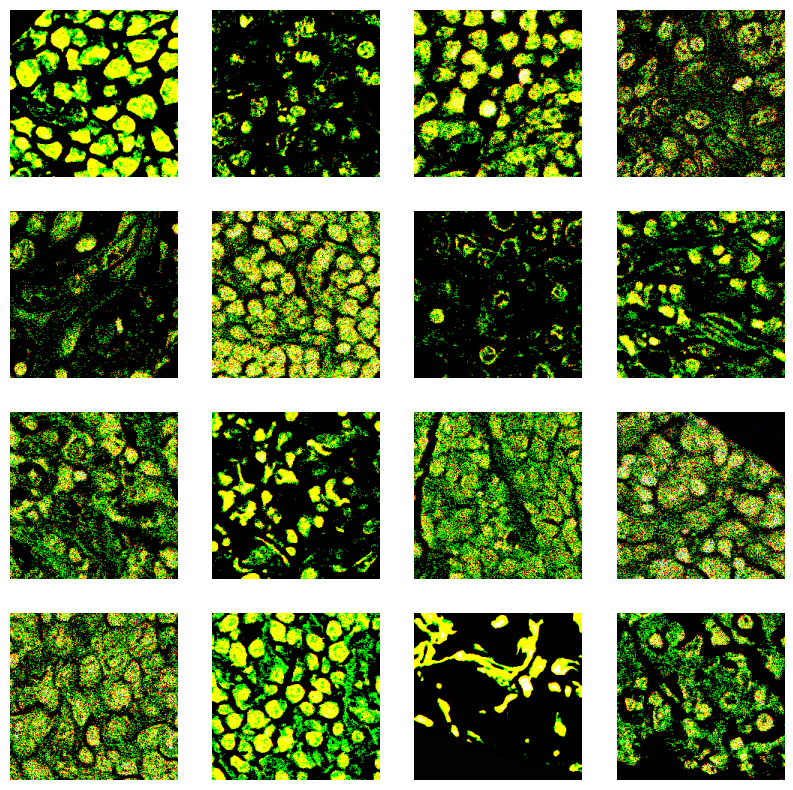

In [11]:
show_batch(batch_)
show_batch(augmented_batch_)
show_batch(preprocessed_augmented_batch)

# Load the model and show the output for the corresponding batch

In [22]:
model = tf.keras.models.load_model("../Models/Model_16_0.0001_18042023_135415/2")

In [23]:
output_batch = model.predict(preprocessed_augmented_batch)

1/1 [==============================] - 4s 4s/step


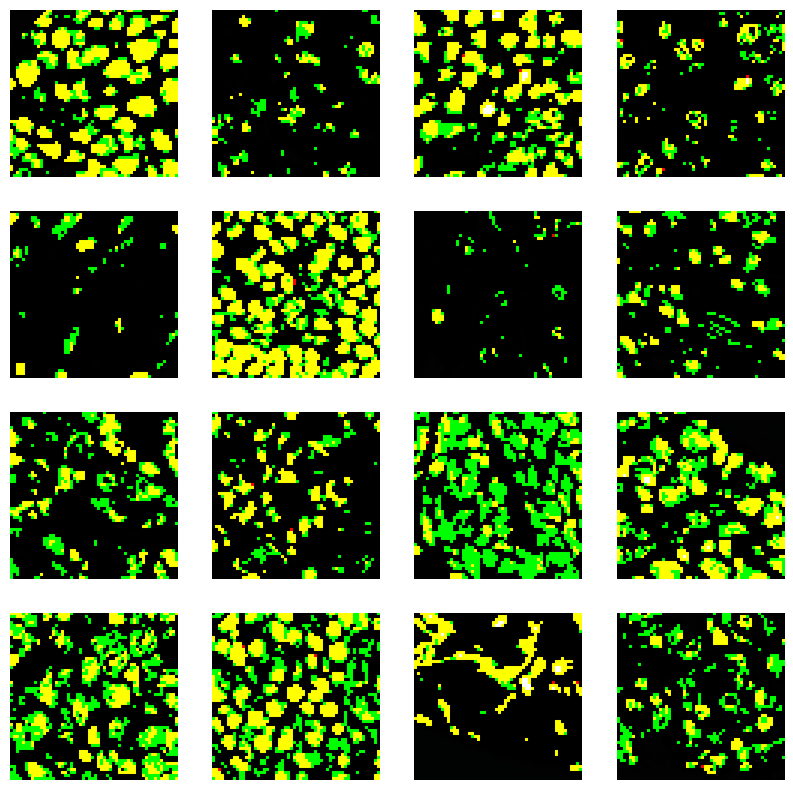

In [24]:
show_batch(output_batch)

In [25]:
# rescale the output to the range [0, 255]
output_batch = (output_batch - output_batch.min()) / (output_batch.max() - output_batch.min())
output_batch = output_batch * 255

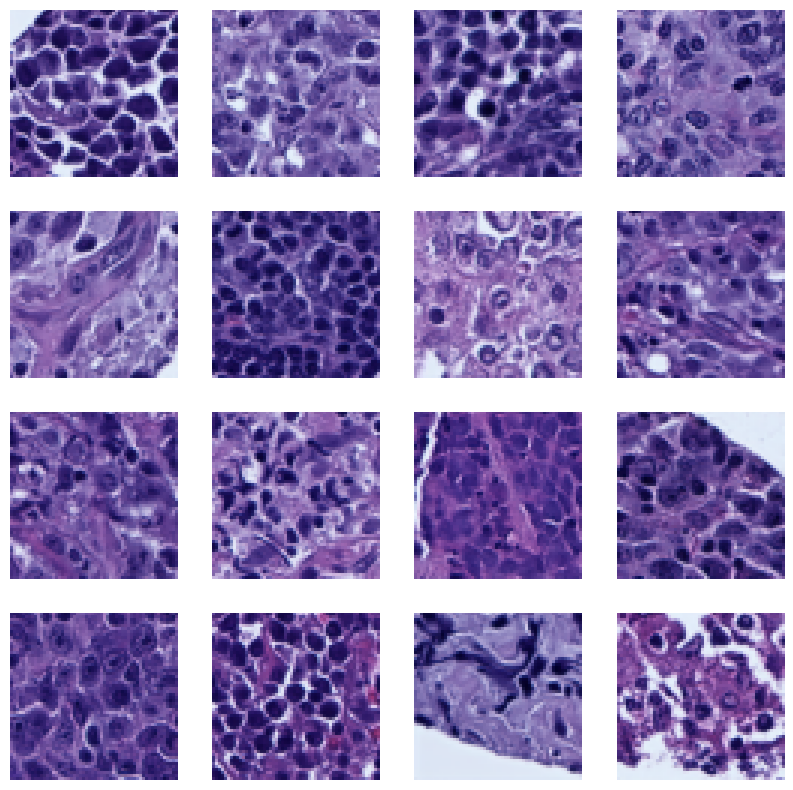

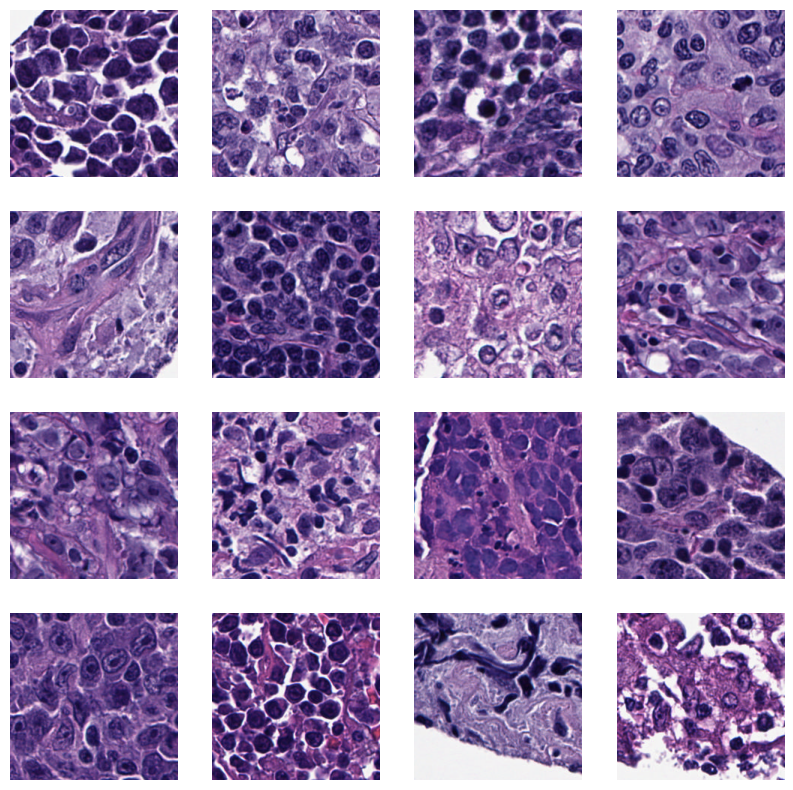

In [26]:
show_batch(output_batch)
show_batch(batch_)

# Show the extracted features from the output layer of the encoder part

In [27]:
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
ae_feature_extractor = Model(inputs=model.layers[-2].inputs, outputs=GlobalAveragePooling2D()(model.layers[-2].outputs[-1]))

In [28]:
batch_features = ae_feature_extractor.predict(preprocessed_augmented_batch)

1/1 [==============================] - 2s 2s/step


In [29]:
# Convert batch_features into a pandas dataframe
import pandas as pd
df = pd.DataFrame(batch_features)

In [32]:
df = df.rename(columns={i: f"feature_{i}" for i in range(len(df.columns))})
df = df.rename(index={i: f"patch_{i}" for i in range(16)})

In [33]:
df

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
patch_0    0.085953   0.072159   0.071443   0.013827   0.055891   0.534233   
patch_1    0.079514   0.023687   0.092272   0.000000   0.236458   0.000000   
patch_2    0.080985   0.022384   0.032811   0.000000   0.115635   0.395376   
patch_3    0.092151   0.009099   0.089150   0.000000   0.262848   0.084387   
patch_4    0.095585   0.036597   0.095274   0.000000   0.316469   0.081973   
patch_5    0.080464   0.005839   0.061483   0.003561   0.111644   0.615586   
patch_6    0.109978   0.055225   0.030099   0.000000   0.281127   0.150793   
patch_7    0.081299   0.014122   0.084853   0.001038   0.130725   0.106391   
patch_8    0.072892   0.002645   0.087295   0.000000   0.171314   0.457578   
patch_9    0.090623   0.013243   0.058236   0.002587   0.086895   0.172288   
patch_10   0.058992   0.017419   0.048812   0.001478   0.054134   1.661357   
patch_11   0.102155   0.086788   0.084463   0.003098   0.216633   0.832591   
patch_12   0.072418   0.000143   0.067241   0.000000   0.112590   0.723134   
patch_13   0.083319   0.019665   0.097818   0.035772   0.020548   0.937411   
patch_14   0.087648   0.135283   0.093848   0.001126   0.294431   0.179522   
patch_15   0.111830   0.156057   0.060490   0.004785   0.319872   1.445429   

          feature_6  feature_7  feature_8  feature_9  ...  feature_1014  \
patch_0    0.083725   0.146348   0.207402   0.008411  ...      0.720295   
patch_1    0.080384   0.156845   0.346019   0.062424  ...      0.071622   
patch_2    0.091224   0.147165   0.185995   0.025109  ...      0.238794   
patch_3    0.075595   0.151791   0.282938   0.022125  ...      0.347488   
patch_4    0.073757   0.158923   0.549468   0.048303  ...      0.453235   
patch_5    0.090595   0.137889   0.059978   0.003413  ...      0.436684   
patch_6    0.067540   0.164080   0.848384   0.058558  ...      2.915886   
patch_7    0.084786   0.155389   0.271234   0.047701  ...      0.312168   
patch_8    0.096104   0.135817   0.325384   0.072695  ...      0.796132   
patch_9    0.077527   0.158061   0.278463   0.048230  ...      1.119929   
patch_10   0.114427   0.123259   0.234438   0.059785  ...      3.289459   
patch_11   0.079523   0.142802   0.430524   0.002404  ...      1.032559   
patch_12   0.097957   0.132263   0.238038   0.044712  ...      0.953487   
patch_13   0.087999   0.138239   0.174259   0.023729  ...      1.141896   
patch_14   0.079403   0.151297   0.287842   0.011698  ...      0.052942   
patch_15   0.070025   0.155119   0.769664   0.005442  ...      2.833570   

          feature_1015  feature_1016  feature_1017  feature_1018  \
patch_0       2.926954      0.300988      0.753346      0.125439   
patch_1       0.190064      1.599277      0.484575      0.264298   
patch_2       3.150100      0.337098      1.278154      0.058134   
patch_3       0.097171      0.470255      0.888183      0.693466   
patch_4       0.097777      0.340665      0.753883      0.111957   
patch_5       0.789164      0.662254      1.347950      0.159428   
patch_6       0.098220      0.194740      2.472890      0.048529   
patch_7       0.535348      1.357795      0.781318      0.368279   
patch_8       0.876465      5.821037      2.596062      2.030630   
patch_9       0.884542      1.327018      2.310298      1.770165   
patch_10      0.058105     14.583631      3.909433      6.435290   
patch_11      3.866845      0.144442      0.272481      0.012537   
patch_12      0.815571      2.977686      2.437423      1.107829   
patch_13      3.003944      1.230138      0.908466      1.297602   
patch_14      0.203869      1.030275      0.168886      0.084472   
patch_15      1.666674      1.199230      0.544728      0.942793   

          feature_1019  feature_1020  feature_1021  feature_1022  feature_1023  
patch_0       1.956961      0.479268      0.721037      0.549445      0.409931  
patch_1       0.317331      0.218057      0.669674      0.346772      2.229516  
patch_2